# Convolution Operation

In this part there are examples that will help understand the basic operation inside **Convolutional Neural Network (CNN)** that is the 2D convolution.

We can load an image from a URL 

In [0]:
import tensorflow as tf
import numpy as np

import requests
from PIL import Image
from io import BytesIO

IMAGE_URL = "http://www.visitgreece.gr/deployedFiles/StaticFiles/Photos/Generic%20Contents/Poleis/white_tower_2_560.jpg"

oResponse = requests.get(IMAGE_URL)
nImageFile = Image.open(BytesIO(oResponse.content))

Using matplotlib we can display the loaded image

(373, 560, 3)


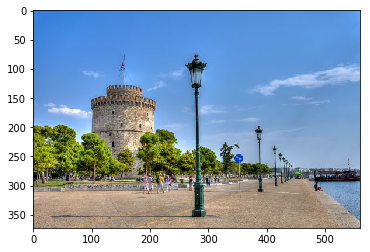

In [2]:
import matplotlib.pyplot as plt

oImagePlot = plt.imshow(nImageFile)

nImageIn = np.array(nImageFile)

print(nImageIn.shape)

The following declares a 2D convolution operation on an RGB image. We are using a 4D tensor for the convolutional kernel, that applies simple sobel filter on each one of the RGB channels, resulting in 3 output channels. You can  apply different filters for each combination of input channel (R,G,B) and output channel (Out1,Out2,Out3)

In [4]:
# Input is a 4D tensor with count of input samples to 1, image spatial dimensions, and 3 channels
nInputShape = [1] + list(nImageIn.shape[:2]) + [3]
print("Input Shape:", nInputShape)
tX = tf.placeholder(tf.uint8, shape=nInputShape)
tIn = tf.cast(tX, tf.float32)/255.0


nZeroChannel      = np.zeros((3,3,1,1), np.float32)

nGaussianFilter   = np.asarray([[1.0/16.0 , 1.0/8.0 , 1.0/16.0], 
                                [1.0/8.0  , 1.0/4.0 , 1.0/8.0], 
                                [1.0/16.0 , 1.0/8.0 , 1.0/16.0]], np.float32).reshape((3,3,1,1))
                                
nDummyFilter      = np.asarray([[0.0, 0.0, 0.0],
                                [0.0, 1.0, 0.0],
                                [0.0, 0.0, 0.0]], np.float32).reshape((3,3,1,1))
                                
nAverageFilter    = np.ones((3,3,1,1), np.float32)*(1.0/9.0)
nSimpleEdgeFilter = np.asarray([[-1.0, 1.0, 0.0],
                                [-1.0, 1.0, 0.0],
                                [-1.0, 1.0, 0.0]], np.float32).reshape((3,3,1,1))
                                
nSobelFilter      = np.asarray([[-1.0, 0.0, 1.0], 
                                [-2.0, 0.0, 2.0], 
                                [-1.0, 0.0, 1.0]], np.float32).reshape((3,3,1,1))

nF_Out1_InR = nSobelFilter
nF_Out1_InG = nZeroChannel
nF_Out1_InB = nZeroChannel

nF_Out2_InR = nZeroChannel
nF_Out2_InG = nSobelFilter
nF_Out2_InB = nZeroChannel

nF_Out3_InR = nZeroChannel
nF_Out3_InG = nZeroChannel
nF_Out3_InB = nSobelFilter

# Compose 3D tensors for each output channel, out of 2D filters
nW_Out1 = np.dstack((nF_Out1_InR,nF_Out1_InG, nF_Out1_InB))
nW_Out2 = np.dstack((nF_Out2_InR,nF_Out2_InG, nF_Out2_InB))
nW_Out3 = np.dstack((nF_Out3_InR,nF_Out3_InG, nF_Out3_InB))

# Compose the 4D tensor that is the convolutional kernel
nW = np.concatenate((nW_Out1, nW_Out2, nW_Out3), axis=3)

print("Convolutional Kernel Shape:", nW.shape)

# Convolution operation that its output will be restrained to [0, 1]
tW = tf.Variable(nW, tf.float32)
tU = tf.nn.conv2d(tIn, tW, strides=[1,2,2,1], padding="SAME")
tA = tf.clip_by_value(tU, 0.0, 1.0)


Input Shape: [1, 373, 560, 3]
Convolutional Kernel Shape: (3, 3, 3, 3)


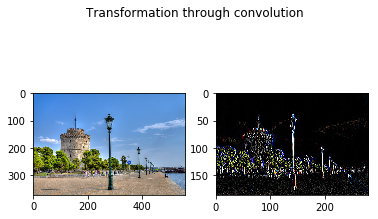

In:(373, 560, 3) -> Out:(1, 187, 280, 3)


In [7]:
with tf.Session() as oSession:
    oSession.run(tf.initializers.global_variables())
    nW = tW.eval()
    
    nRepresentationsOut = oSession.run(tA, feed_dict={tX:nImageIn[np.newaxis, ...]})
    nImageOut = (nRepresentationsOut[0,...]*255.0).astype(np.uint8)
    
    
    nFigure, nAxis = plt.subplots(1,2)
    nFigure.suptitle("Transformation through convolution")
        
    nAxis[0].imshow(nImageIn)
    if nImageOut.shape[2] == 1:
        nAxis[1].imshow(nImageOut[:,:,0], cmap="gray")
    else:
        nAxis[1].imshow(nImageOut)

    plt.show()
    
    print("In:%s -> Out:%s" % (nImageIn.shape, nRepresentationsOut.shape))


## Understanding Convolutional Layer

The 2D convolution operation on the pixels of an RGB color image, could be considered as a transformation of `n=3` input features to `m` output features. There are `m*n` different filters that are applied to patches of the image, using a window (3x3) that slides over the input with a given stride (2 pixels). Any stride `s>1` would result in spatial downsampling of the image (373x560 becomes 187x280).

Through a learning process the filters in each convolutional kernel are learned from data, thus the kernels hold the model parameters (or weights). There could be an increase in the dimensionality of features as the spatial dimensions are decreasing.
